In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns

from matplotlib.animation import FuncAnimation
import os
import time
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Hernquist Density Profile
The density is given by (Galactic Dynamics, James Binney- pg 70):

$$
    \rho(r) = \frac{\rho_0 Rs^4}{r (r + Rs)^3}.
$$

where $Rs$ is the scale radius.

The mass within a given radius r is:

$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 Rs \frac{r^2}{2(1 + \frac{r}{Rs})^2}.
$$
The total mass of the distribution is: 

$$
    M_{tot} = 2 \pi \rho_0 R_s^3 \longrightarrow \rho_0 = \frac{M_{tot}}{2 \pi R_s^3}.
$$

The cumulative distribution function for the radii is:

$$
    P(r) = \frac{M(r)}{M_{tot}} = \frac{r^2}{Rs^2(1 + \frac{r}{Rs})^2} = \frac{r^2}{(Rs + r)^2} 
$$

Inverting this equation, we can find the inverse cumulative distribution function:

$$
    r(P) = \frac{\sqrt{P} Rs}{1 - \sqrt{P}}
$$

The distribution function for $\theta$ and $\phi$ are the ones of a spherically symmetric system:

$$
    P(\phi) = \frac{1}{2 \pi},
$$
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos\theta \right).
$$

In [2]:
N = 10000
M = 1
m = M/N
Rs = 1

rho_0 = M / (2 * np.pi * (Rs)**3)

## Density Profile

In [3]:
def H_profile(r, Rs, rho_0):
    return (rho_0 * (Rs**4)) / (r * ((r + Rs)**3))

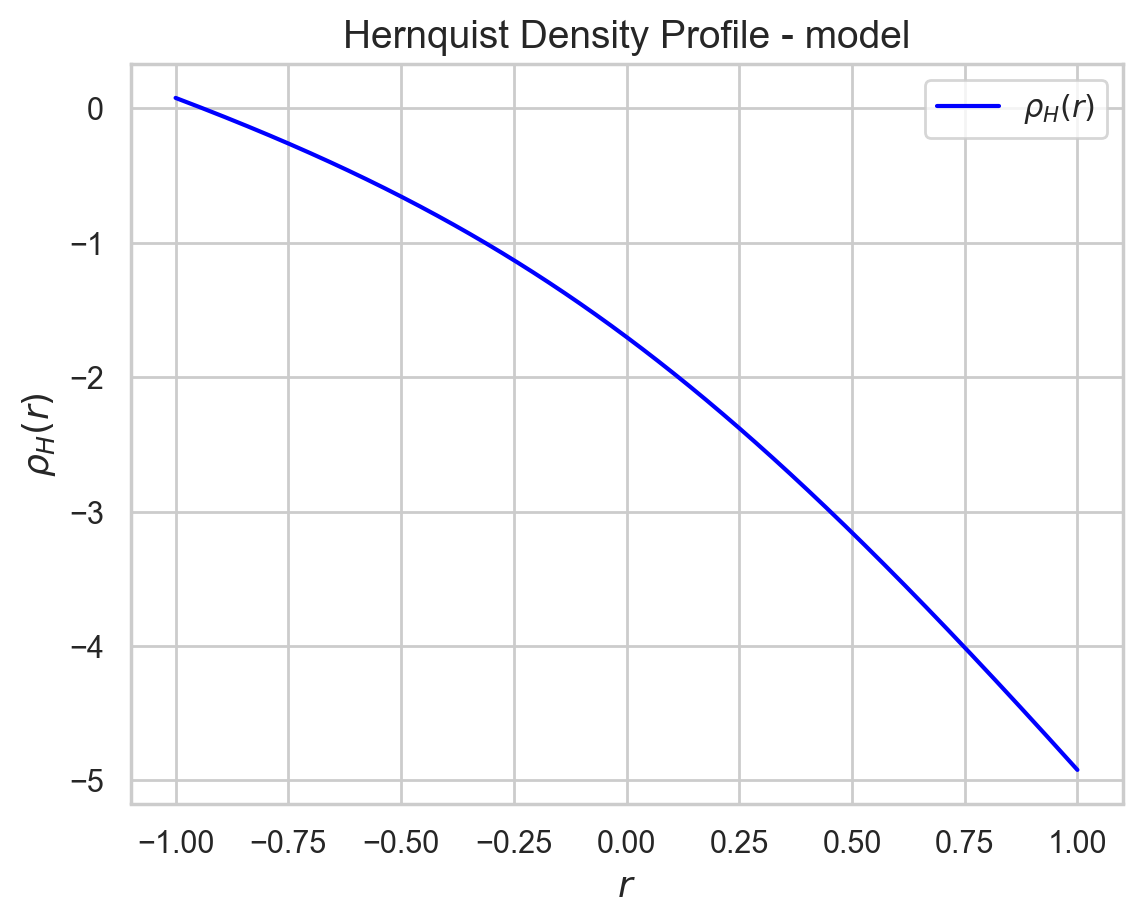

In [4]:
sns.set(style="whitegrid")

raggi = np.linspace(0.1, 10*Rs, N)
rho_H = H_profile(raggi, Rs, rho_0)

plt.plot(np.log10(raggi), np.log10(rho_H), color='blue', label=r'$\rho_H(r)$')
plt.title('Hernquist Density Profile - model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)
plt.legend()


# DISTRIBUTION INITIALIZATION

### Positions Sampling

In [5]:
def inv_cumulative(Rs, N):
    c = np.random.uniform(0.0001, 0.9999, size=N)
    return np.sqrt(c)*Rs / (1-np.sqrt(c))

In [6]:
# Raggi delle particelle
radii = inv_cumulative(Rs, N)

# Theta
cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
theta = np.arccos(1 - 2 * cdf_theta)

# Phi
phi = uniform.rvs(0, 2 * np.pi, size=N)

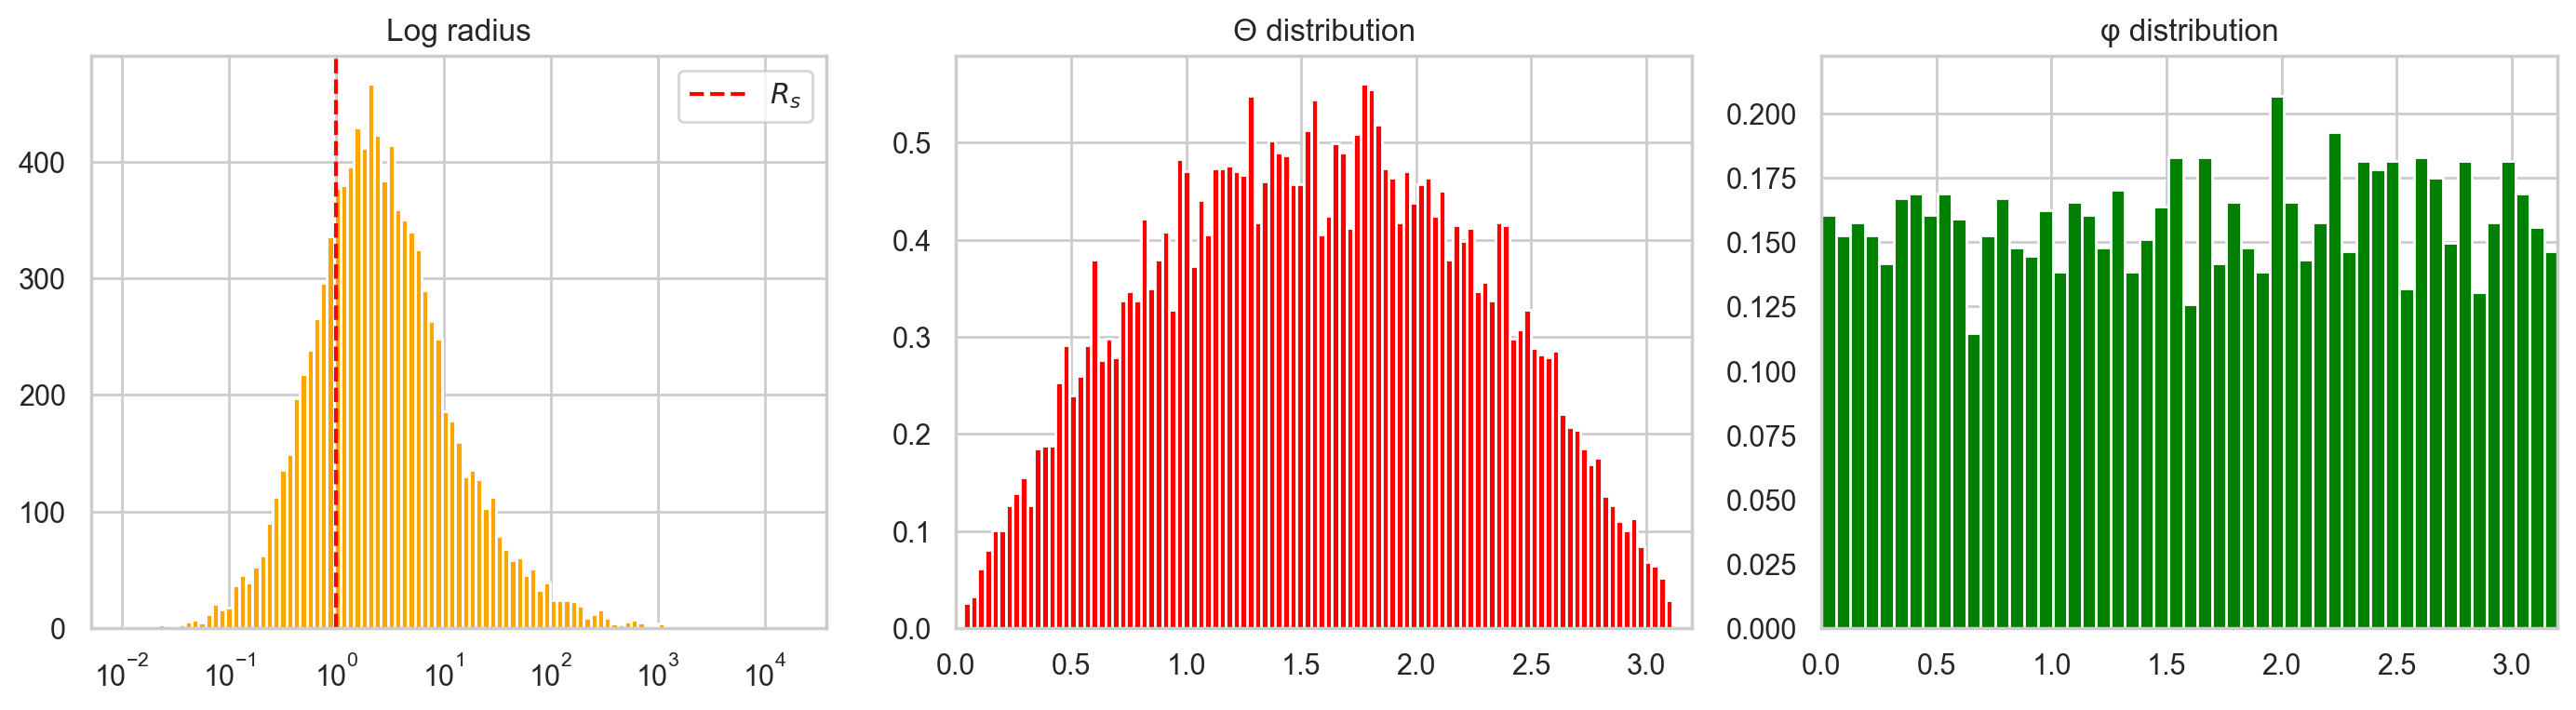

In [7]:

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(radii, bins=np.logspace(np.log10(np.min(radii)), np.log10(np.max(radii)), 100), color='orange')
axes[0].axvline(x=Rs, linestyle='--', color='red', label=r'$R_s$')
axes[0].set_title('Log radius')
axes[0].set_xscale('log')
axes[0].legend()

axes[1].hist(theta, bins=100, density=True, color='red')
axes[1].set_title("Θ distribution")
axes[1].set_xlim(0,3.2)

axes[2].hist(phi, bins=100, density=True, color='green')
axes[2].set_title("φ distribution")
axes[2].set_xlim(0,3.2)

plt.tight_layout()


In [8]:
def calculate_radius(r, percentage):
    # Calculation of the radius containing a certain percentage of particles.
    
    sorted_r = np.sort(r)
    
    index = int(len(sorted_r) * percentage / 100)
    radius = sorted_r[index]
    
    return radius

##################################################################################à

percentage = 75  

radius = calculate_radius(radii, percentage)
print(f"Radius within which {percentage}% of the particles lie: {radius}")
print("Expected radius : ", np.sqrt(0.75)*Rs / (1-np.sqrt(0.75)))

Radius within which 75% of the particles lie: 6.462528301222965
Expected radius :  6.464101615137752


### Cartesian coordinates

In [9]:
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)

In [10]:
# Center  of Mass
x_cm = np.sum(m * x)/M
y_cm = np.sum(m * y)/M
z_cm = np.sum(m * z)/M
x_cm, y_cm, z_cm

(-1.3347103457097154, 0.011647901000247207, -0.08956288767226328)

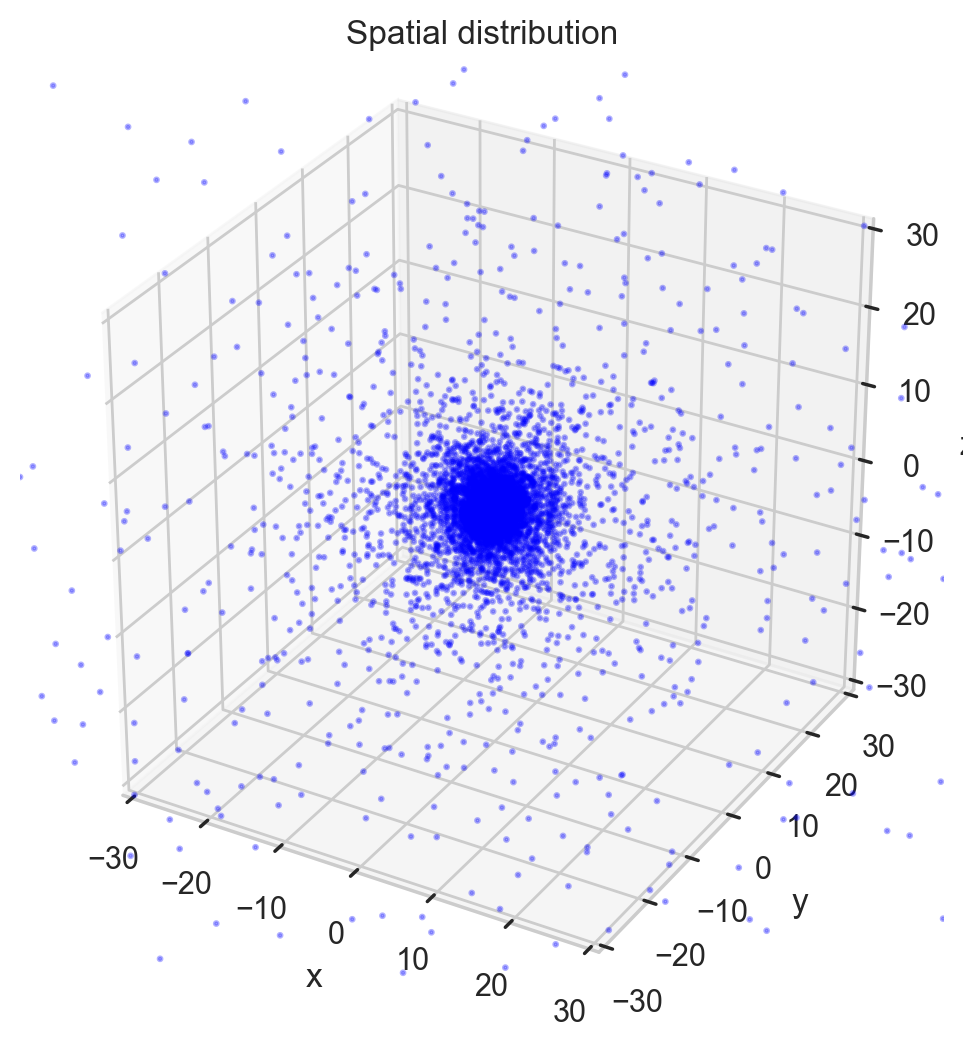

In [11]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c = 'blue', s=2, alpha = 0.3)
ax.set_box_aspect([1,1,1])
#ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_title("Spatial distribution")
ax.set_box_aspect([1,1,1])

plt.show();

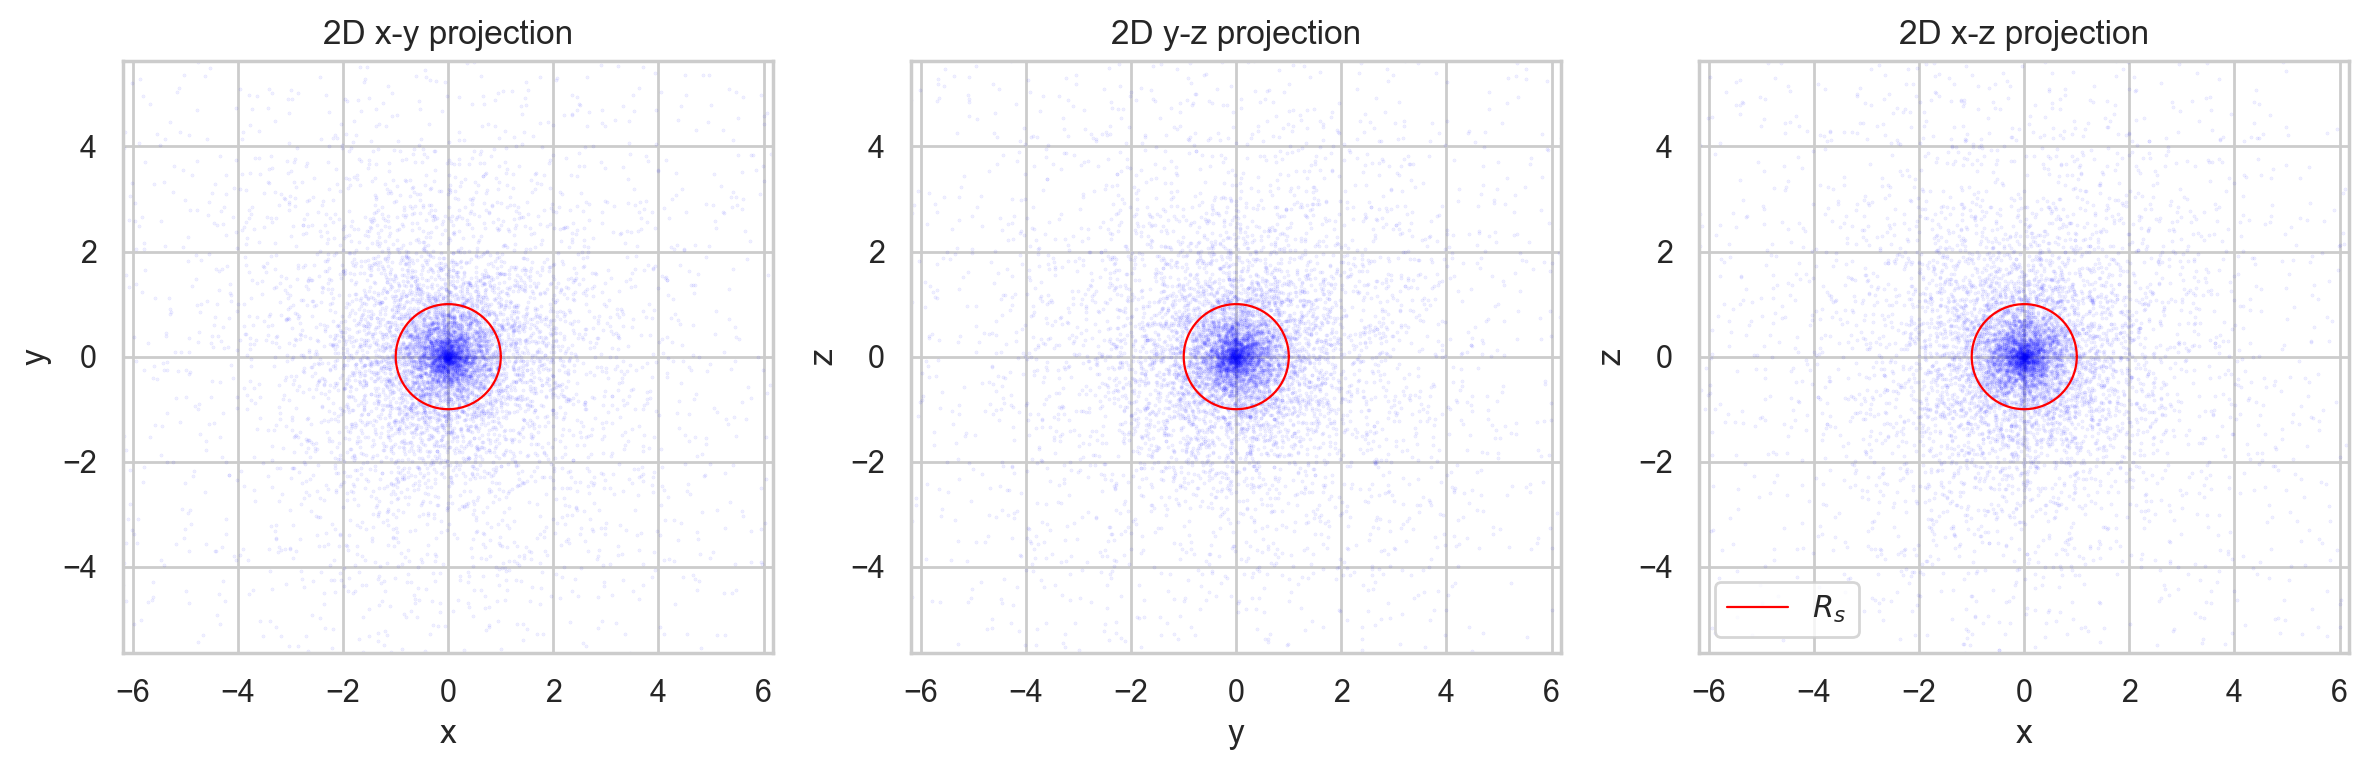

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)
a = Rs * np.cos( theta )
c = Rs * np.sin( theta )
axes[0].scatter(x, y, c='blue', s=0.1, alpha=0.1)
axes[0].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[0].axis('equal')
axes[0].set_xlim(-5, 5)
axes[0].set_ylim(-5, 5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(y, z, c='blue', s=0.1, alpha=0.1)
axes[1].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[1].axis('equal')
axes[1].set_xlim(-5, 5)
axes[1].set_ylim(-5, 5)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(x, z, c='blue', s=0.1, alpha=0.1)
axes[2].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[2].axis('equal')
axes[2].set_xlim(-5, 5)
axes[2].set_ylim(-5, 5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()

### Check the density distribution

In [13]:
# create 29 spherical shells within which I compute the density

shell_r = np.linspace(np.min(radii), 20*Rs, 100)
num_part = []
volume = []

for i in range(1, len(shell_r)):
    count = sum(1 for r in radii if r > shell_r[i-1] and r < shell_r[i])
    volume.append(4/3 * np.pi * (shell_r[i]**3 - shell_r[i-1]**3))
    num_part.append(count)
    
num_part = np.array(num_part)
volume = np.array(volume)

rho_check = m * num_part / volume

# Rimuovo il primo elemento da rays per fare il plot
shell_r = shell_r[1:]

rho_th = H_profile(shell_r, Rs, rho_0)

Text(0.5, 1.0, 'Density Profile')

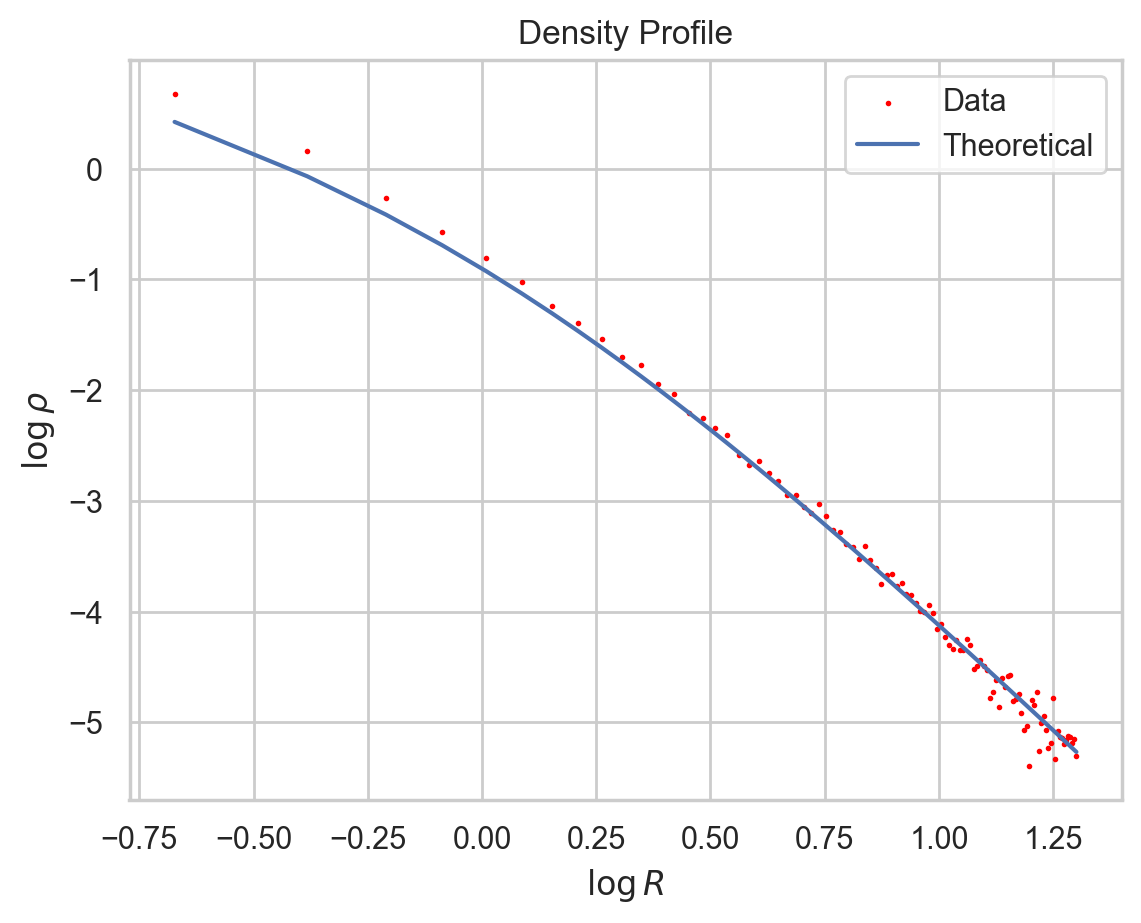

In [14]:
plt.scatter(np.log10(shell_r), np.log10(rho_check/rho_0), label='Data', color='red', s=1)
plt.plot(np.log10(shell_r), np.log10(rho_th/rho_0), label='Theoretical')
plt.legend()
plt.xlabel(r'$\log{R}$')
plt.ylabel(r'$\log{\rho}$')
plt.title('Density Profile')

## Hernquist Potential

The potential is:

$$
    \Phi(r) =-  4 \pi G \rho_0 Rs^2 \frac{1}{2(1+ \frac{r}{Rs})}
$$

In [15]:
def H_pot(radii, Rs, rho_0):
    return - 2 * np.pi * rho_0 * Rs**2 / (1 + radii/Rs)

In [16]:
Psi = H_pot(radii, Rs, rho_0)   # Potenziale di ogni particella

Text(0, 0.5, '$\\Phi_H(r)$')

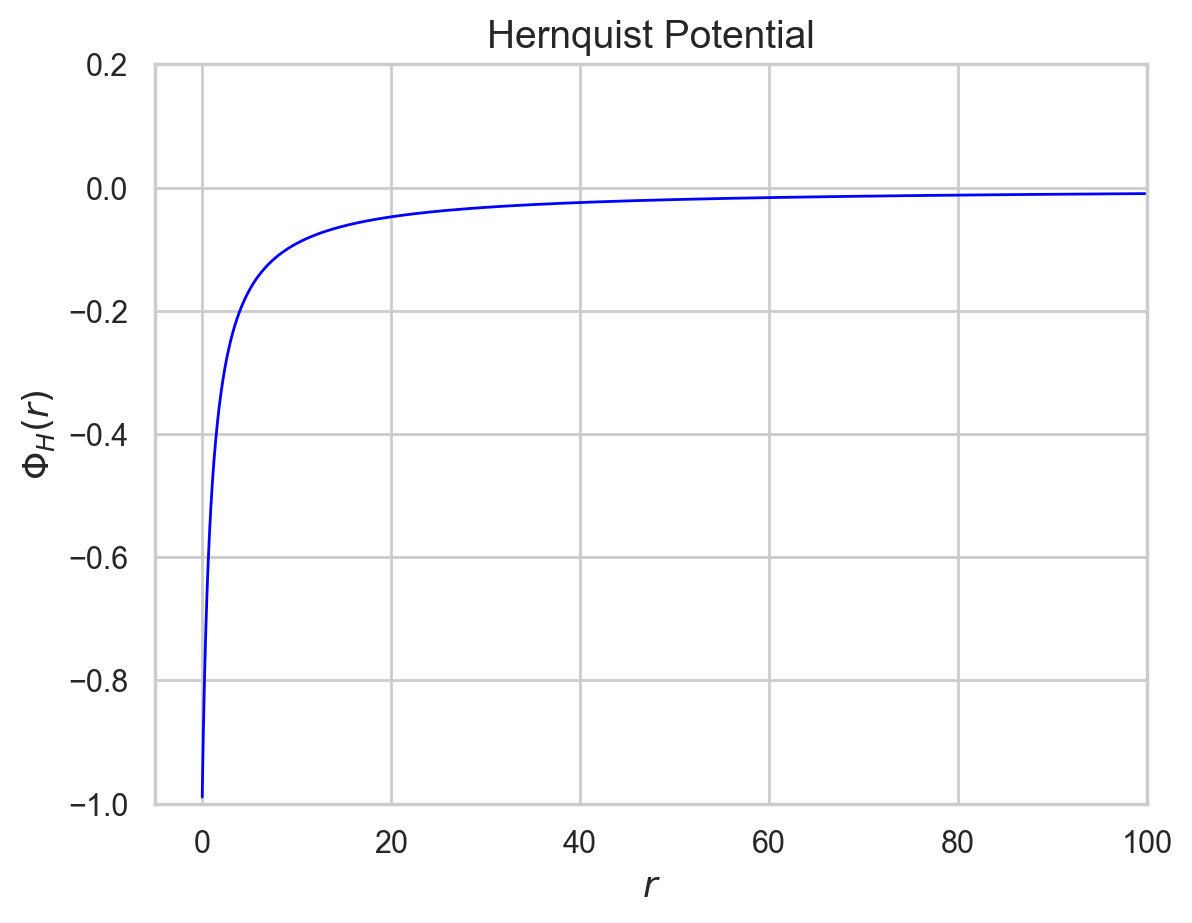

In [17]:
# Set Seaborn style
sns.set(style="whitegrid")
plt.plot(np.sort(radii), np.sort(Psi), color='blue', linewidth=1.0)
plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.xlim(-5, 100)
plt.ylim(-1, 0.2)
plt.ylabel(r'$\Phi_H(r)$', fontsize=13)

## Distribution Function
Page 302
$$
    f_H(\epsilon)=\frac{1}{\sqrt{2}(2 \pi)^3 (GM R_s)^{\frac{3}{2} }  } \frac{\sqrt{\epsilon}}{(1- \epsilon)^2} \left[ (1-2\epsilon) (8\epsilon ^2 - 8 \epsilon -3) + \frac{3 sin^{-1} \sqrt{\epsilon}}{\sqrt{\epsilon (1 - \epsilon)}}    \right]
$$
where $\epsilon = -\frac{E R_s}{GM}$

In [18]:
#DF in funzione epsilone

def df_eps(E, Rs, M):
    epsilon = (E*Rs)/M
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * (( M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result



# df in funzione di q
def df_q(q, Psi, Rs, M):
    
    epsilon = - Psi * (1-q**2)
    
    term1 = 1 / ( np.sqrt(2) * ((2* np.pi)**3) * ((M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result    

(-0.1, 1.5)

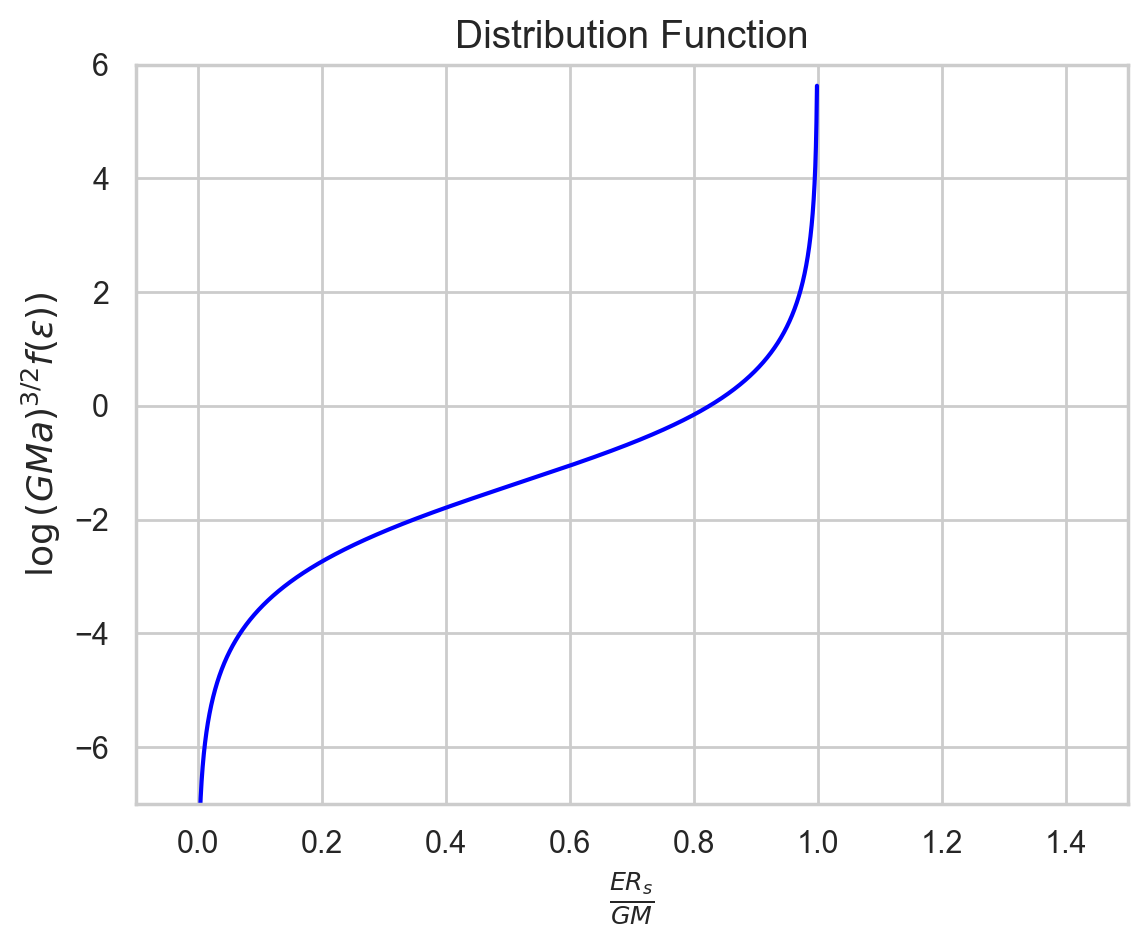

In [19]:
# I plot the distribution function in the same way it's plotted on the book to check if it's correct

asse_x = np.linspace(0.001, 0.999, N) 

E       = asse_x * (M/Rs)
epsilon = (E*Rs)/(M)
df      = df_eps(epsilon, Rs, M)

asse_y = np.log10(((M*Rs)**(3/2)) * df)

sns.set(style="whitegrid")


plt.plot(E, asse_y, color='blue')
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

plt.ylim(-7,6)
plt.xlim(-0.1,1.5)

# MC rejection method
Ie use the Monte Carlo rejection method to sample the escape velocit ration $q = \frac{v}{v_{esc}}$ from which I can then find $v$.

$$ F(\varepsilon) = \int_0^{\varepsilon} f(\varepsilon) d^3 v = \int_0^{\varepsilon} f(\varepsilon)  4 \pi v^2 dv \propto  \int_0^1 f\left(-\Psi (1-q^2)\right)  4 \pi (- 2 \Psi q^2)  \sqrt{- 2 \Psi} dq
$$.

In [20]:
def F(df, q, psi):
    return df * 4 * np.pi * (- 2 * psi * q**2) * np.sqrt(- 2 * psi)

In [21]:
qs = []

for psi in tqdm(Psi):
    q = random.uniform(0.0001,0.9999)
    currentF = F(df_q(q, psi, Rs, M), q, psi)
    max_F = np.max(currentF)
    y_rand = random.uniform(0, max_F)
    
    while(y_rand > F(df_q(q, psi, Rs, M), q, psi)):
        q = random.uniform(0.0001, 0.9999)
        currentF = F(df_q(q, psi, Rs, M), q, psi)
        max_F = np.max(currentF)
        y_rand = random.uniform(0, max_F)
        
    qs.append(q)
          
qs = np.array(qs)

100%|██████████| 10000/10000 [00:01<00:00, 9934.22it/s]


### Velocities

In [22]:
v = qs * np.sqrt(-2*Psi)
v = v / 1.15

vel_theta_cdf = np.random.uniform(0, 1, N)
vel_theta = np.arccos(1 - 2 * vel_theta_cdf)

vel_phi = np.random.uniform(0, 2*np.pi, size=N)

##########################################

v_x = v * np.sin(vel_theta) * np.cos(vel_phi)
v_y = v * np.sin(vel_theta) * np.sin(vel_phi)
v_z = v * np.cos(vel_theta)

Text(0.5, 1.0, 'Velocities distribution')

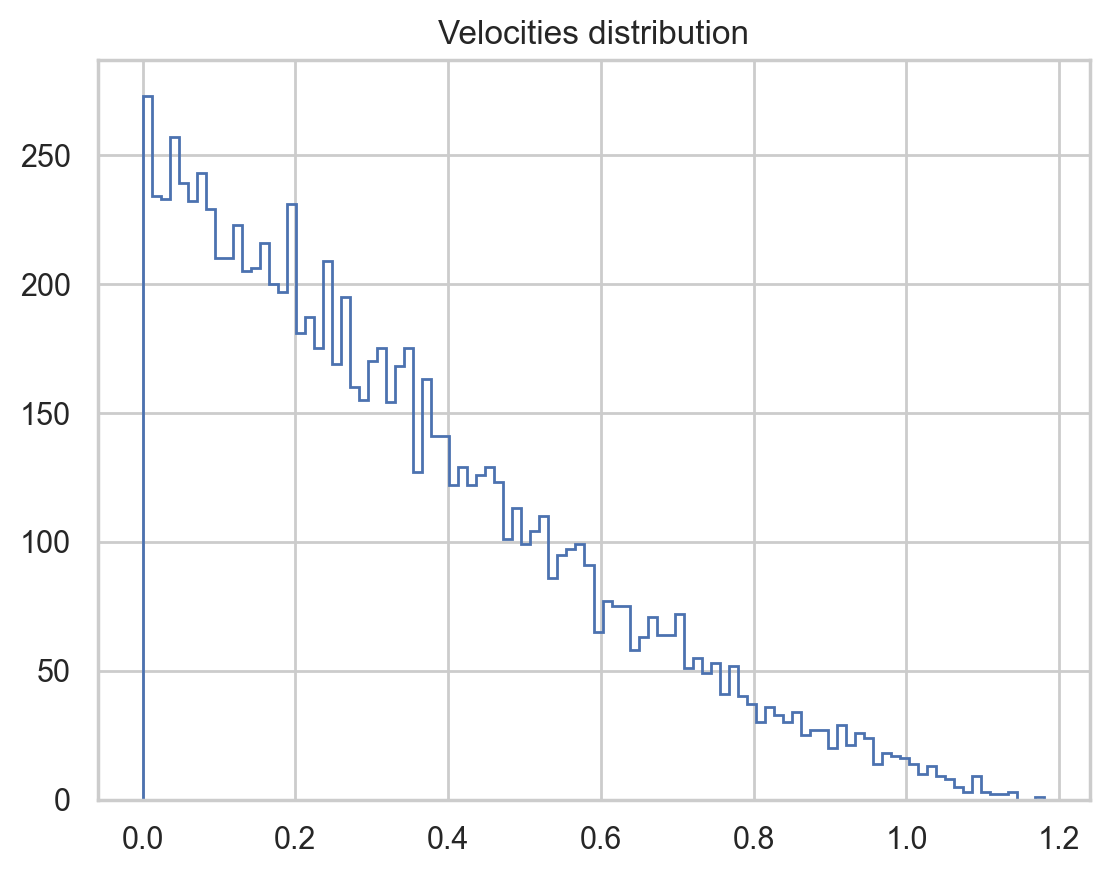

In [23]:
plt.hist(v, bins=100, histtype='step')
plt.title('Velocities distribution')

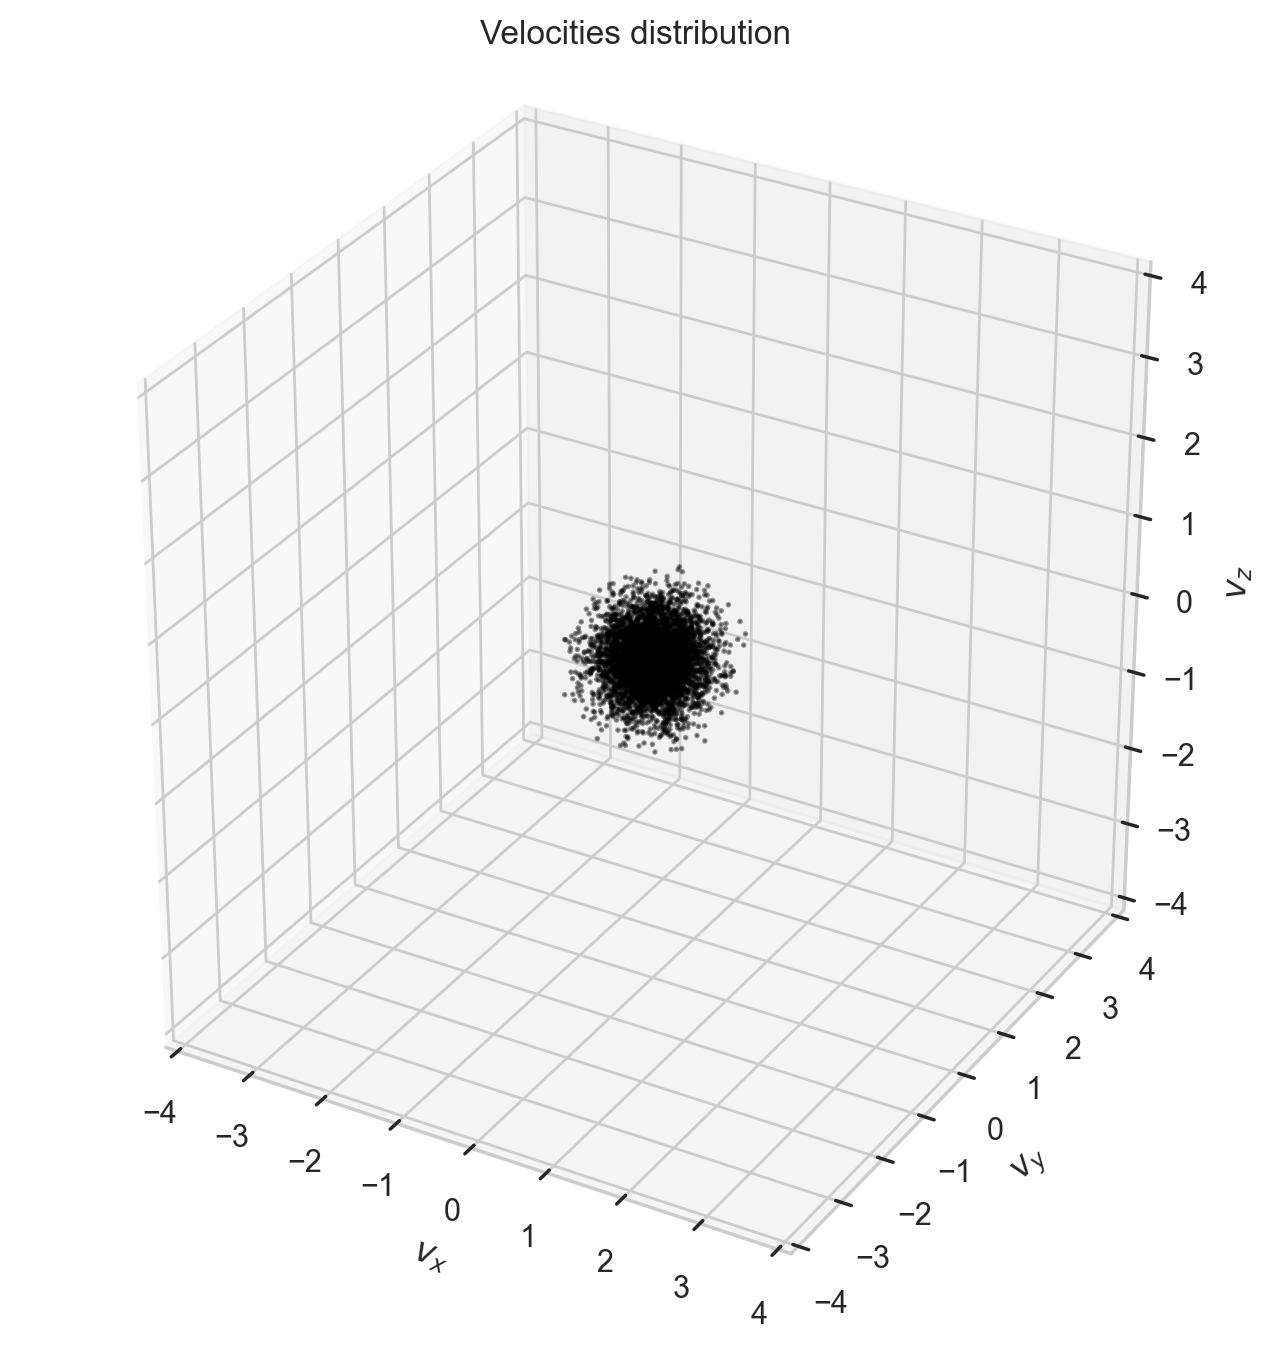

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(v_x, v_y, v_z, c = 'black', s=1, alpha=0.4)
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
ax.set_title("Velocities distribution")
plt.show();

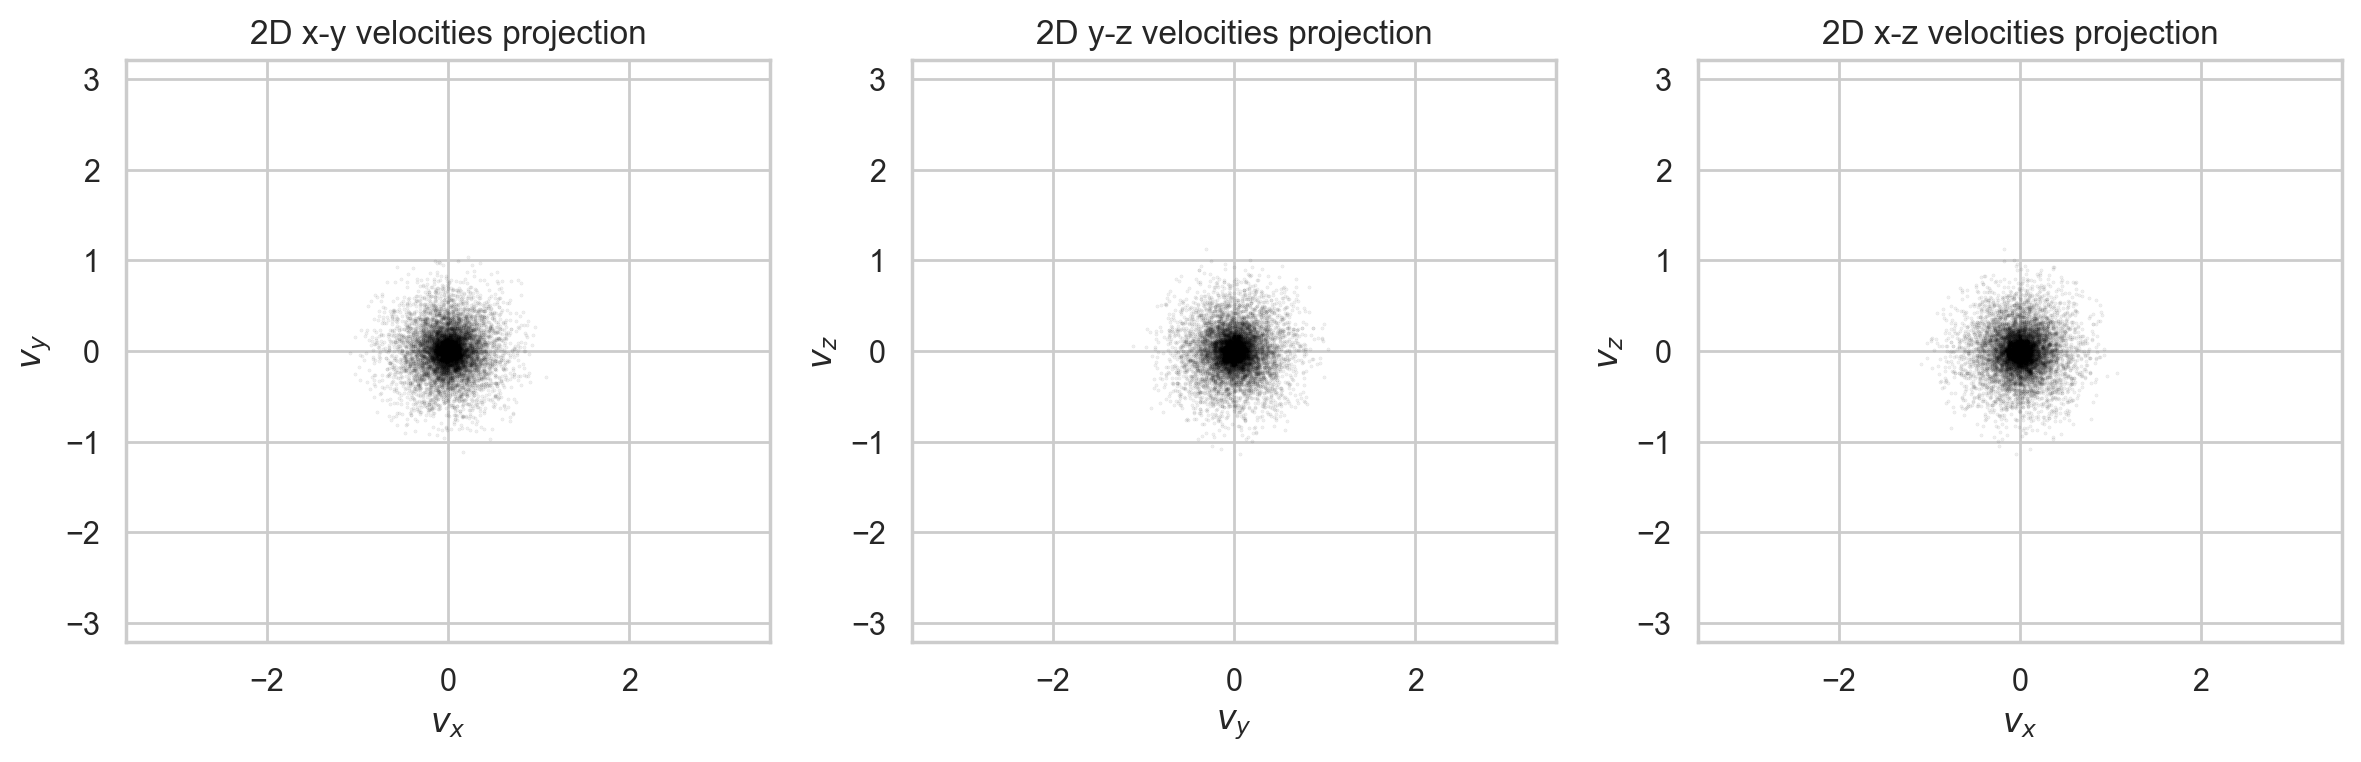

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)

axes[0].scatter(v_x, v_y, c='black', s=0.1, alpha=0.1)
#axes[0].plot(a, c, c='red', label=r'$v_{esc}$', linewidth=4)
axes[0].axis('equal')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_xlabel(r'$v_x$')
axes[0].set_ylabel(r'$v_y$')
axes[0].set_title('2D x-y velocities projection')


# Projection on y-z plane
axes[1].scatter(v_y, v_z, c='black', s=0.1, alpha=0.1)
axes[1].axis('equal')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_xlabel(r'$v_y$')
axes[1].set_ylabel(r'$v_z$')
axes[1].set_title('2D y-z velocities projection')



# Projection on x-z plane
axes[2].scatter(v_x, v_z, c='black', s=0.1, alpha=0.1)
axes[2].axis('equal')
axes[2].set_xlim(-4, 4)
axes[2].set_ylim(-4, 4)
axes[2].set_xlabel(r'$v_x$')
axes[2].set_ylabel(r'$v_z$')
axes[2].set_title('2D x-z velocities projection')


plt.tight_layout()
plt.show()

### Check the velocities
They need to be smaller than the escape velocity

In [26]:
v_esc = np.sqrt(- 2 * np.sort(Psi))

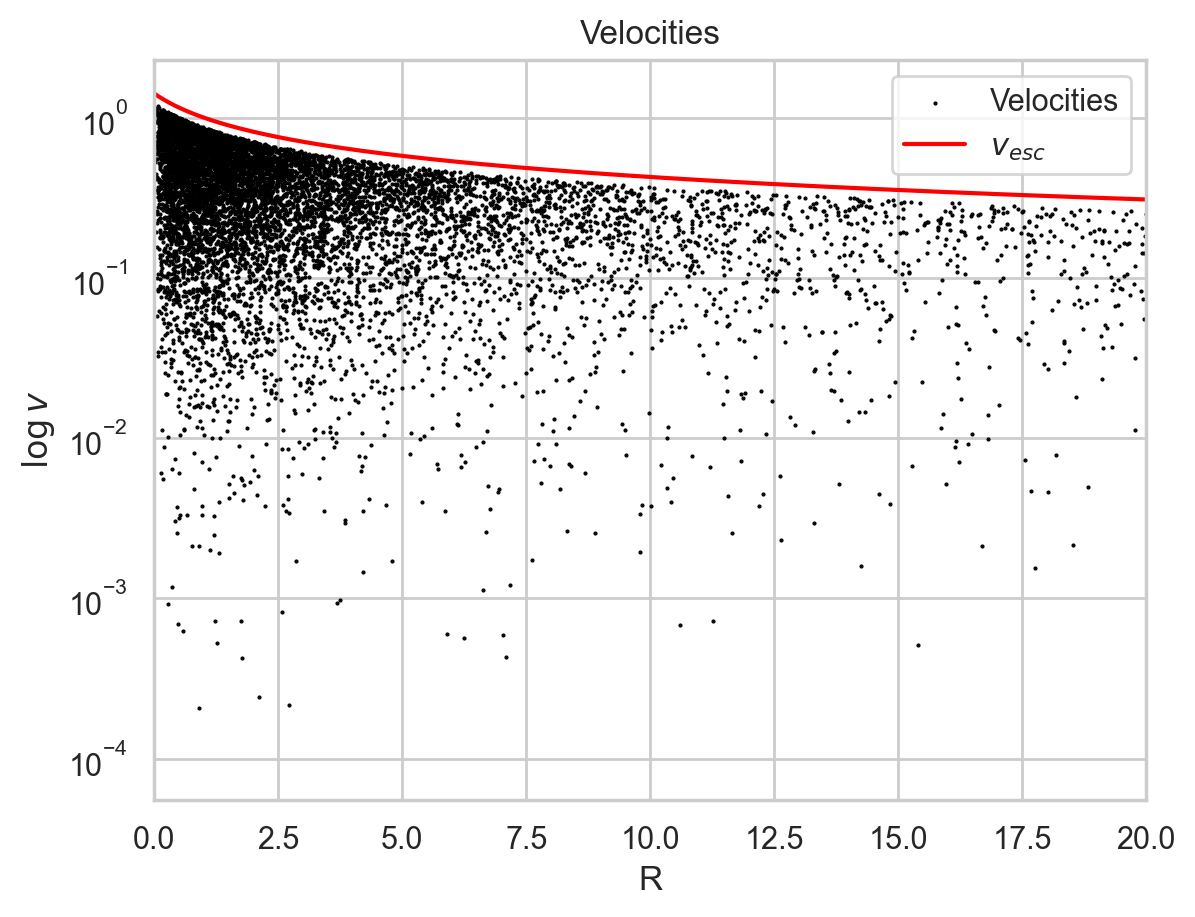

In [27]:
plt.scatter(radii, v, marker='.', s=1, color='black', label='Velocities')
plt.plot(np.sort(radii), v_esc, color='red', label=r'$v_{esc}$')
plt.xlabel('R')
plt.ylabel(r'$\log{v}$')
plt.xlim(0, 20)
plt.yscale('log')
plt.title('Velocities')
plt.legend()

# Perturber

In [28]:
# mass
m_pert = 0.03 * M

# position
x_pert = 0.8 #inside scale radius
y_pert = 0
z_pert = 0

r_pert = np.sqrt(x_pert**2 + y_pert**2 + z_pert**2)

# velocity
Psi_pert = H_pot(r_pert, Rs, rho_0)
v_pert   = ( np.sqrt(- 2 * Psi_pert) ) / np.sqrt(2) # escape / const to make it smaller

vx_pert = 0
vy_pert = v_pert
vz_pert = 0

In [29]:
# add the perturber
N_p = N + 1

## Initial conditions

In [30]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_H_pert.txt', 'w+') as f:
    f.write(str(N_p) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    f.write(f'{m_pert}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    f.write(f'{x_pert} {y_pert} {z_pert}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')
    f.write(f'{vx_pert} {vy_pert} {vz_pert}' + '\n')

In [31]:
T_dyn = (3*np.pi/(16*rho_0))**(1/2)
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(10 * T_dyn)
print("Simulation time: ", T_sim)

dt = 1/200
theta = 0.2
t_out = dt*100


Dynamical Time:  1.9238247452427961
Epsilon:  0.0075
Simulation time:  19.0


In [32]:
print('./treecode in=in_H_pert.txt dtime='+ str(dt) + ' eps='+str(epsilon)+' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=out_H_pert.txt >logout_H_pert.txt')

./treecode in=in_H_pert.txt dtime=0.005 eps=0.0075 theta=0.2 tstop=19.0 dtout=0.5 out=out_H_pert.txt >logout_H_pert.txt


# ANALYSIS

In [33]:
lines = pd.read_csv('out_H_pert.txt', names = list(range(3)), sep = '\s+')
N_particles = N_p
s = N_p*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s_tot  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N_p+3)])
x_s_tot  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N_p+3, 2*N_p+3)])
y_s_tot  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N_p+3, 2*N_p+3)])
z_s_tot  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N_p+3, 2*N_p+3)])
vx_s_tot = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N_p+3, 3*N_p+3)])
vy_s_tot = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N_p+3, 3*N_p+3)])
vz_s_tot = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N_p+3, 3*N_p+3)])

#calcolo raggi
r_s_tot = np.sqrt(x_s_tot**2 + y_s_tot**2 + z_s_tot**2)

# sono del tipo (particella, tempo)

In [34]:
# particles
x_s = x_s_tot[0: -1 , :]
y_s = y_s_tot[0: -1 , :]
z_s = z_s_tot[0: -1 , :]

vx_s = vx_s_tot[0: -1 , :]
vy_s = vy_s_tot[0: -1 , :]
vz_s = vz_s_tot[0: -1 , :]

r_s = r_s_tot[0: -1 , :]

# perturber 
xp_s = x_s_tot[-1, :]
yp_s = y_s_tot[-1, :]
zp_s = z_s_tot[-1, :]

vpx_s = vx_s_tot[-1, :]
vpy_s = vy_s_tot[-1, :]
vpz_s = vz_s_tot[-1, :]

rp_s = r_s_tot[-1, :]

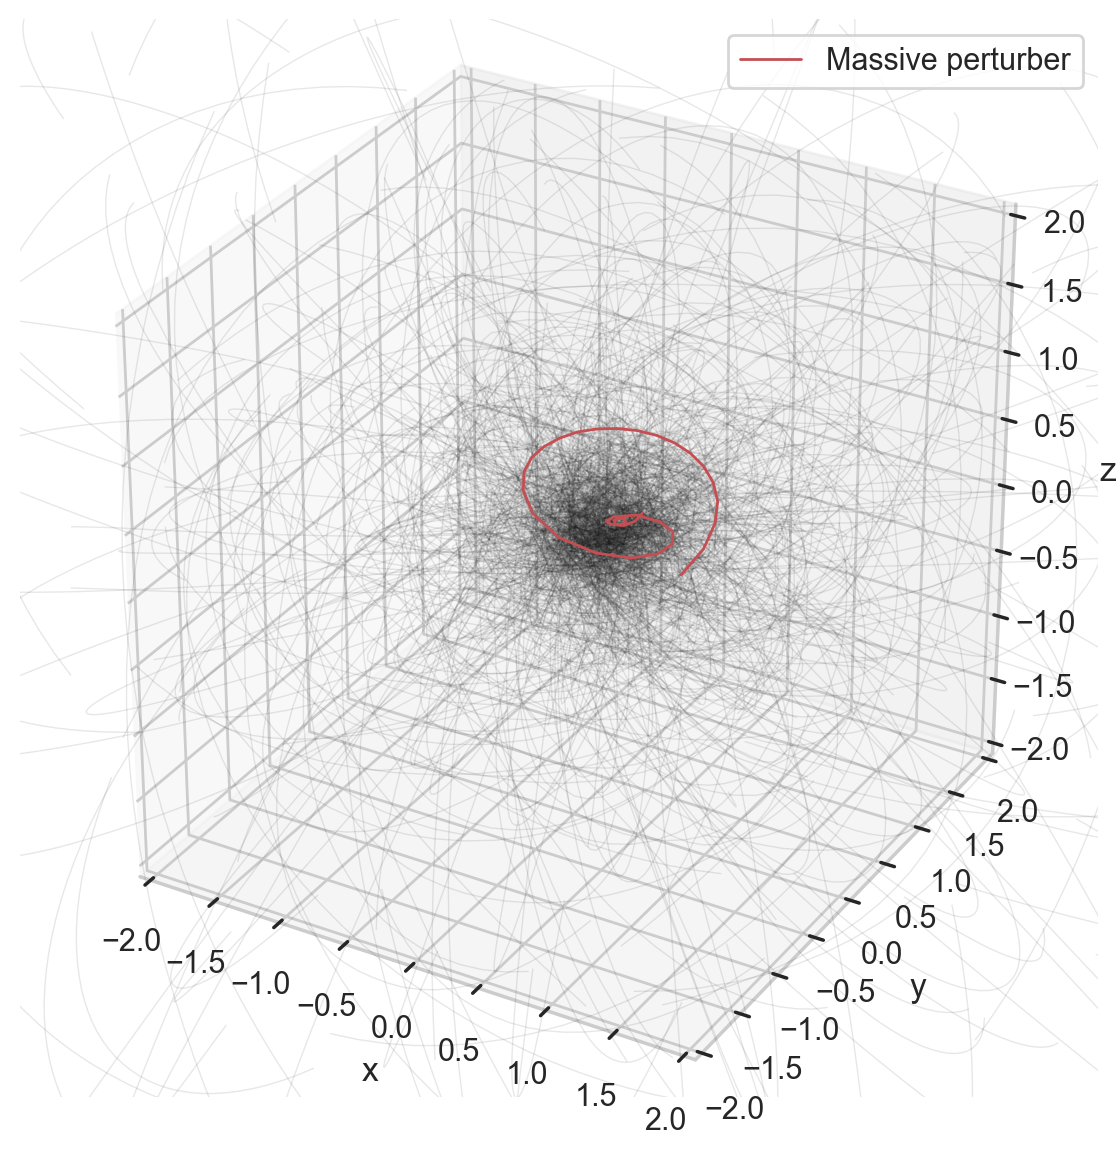

In [35]:
l=2

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-l, l)
ax.set_ylim(-l, l)
ax.set_zlim(-l, l)
ax.set_box_aspect([1,1,1])

ax.plot(xp_s, yp_s, zp_s, linewidth=1, c='r', zorder=2, label='Massive perturber')

for n in (range(500)):
    ax.plot(x_s[n, :], y_s[n, :], z_s[n, :], linewidth=0.5, c='k', alpha=0.1, zorder=1)
ax.legend()

  0%|          | 0/38 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


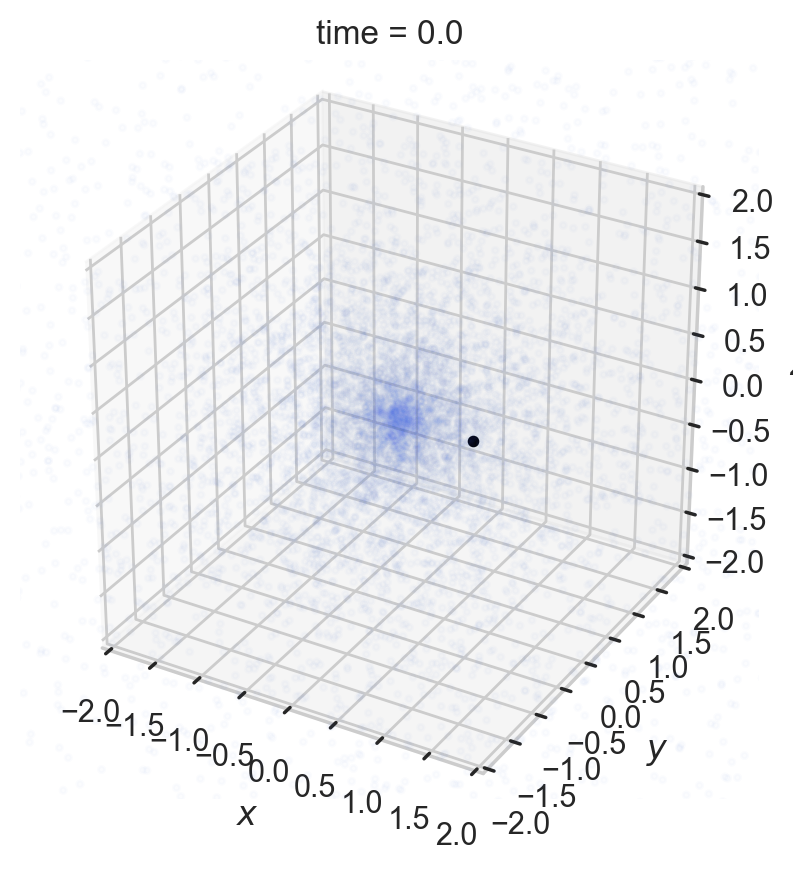

In [36]:
# ANIMATION 

from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.rcParams['animation.embed_limit'] = 100.0  # Imposta il limite a 50 MB o a un valore più grande se necessario

def update(num):
    global N    #N_particles
    l = 2
    ax.clear()
    
    ax.scatter(x_s[:,num], y_s[:,num], z_s[:,num], color = 'royalblue', s = 5 ,alpha = .02)        # Updating Point Location
    ax.scatter(xp_s[num], yp_s[num], zp_s[num], color = 'black', s = 10)
    
    ax.set_title(f'time = {round(t_s[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='equal')
line_ani = animation.FuncAnimation(fig, update, interval=130,   
                                   frames=tqdm(range(len(t_s) - 1)));

HTML(line_ani.to_jshtml())
line_ani.save(f'Hernquist_pert.gif')

### center of mass

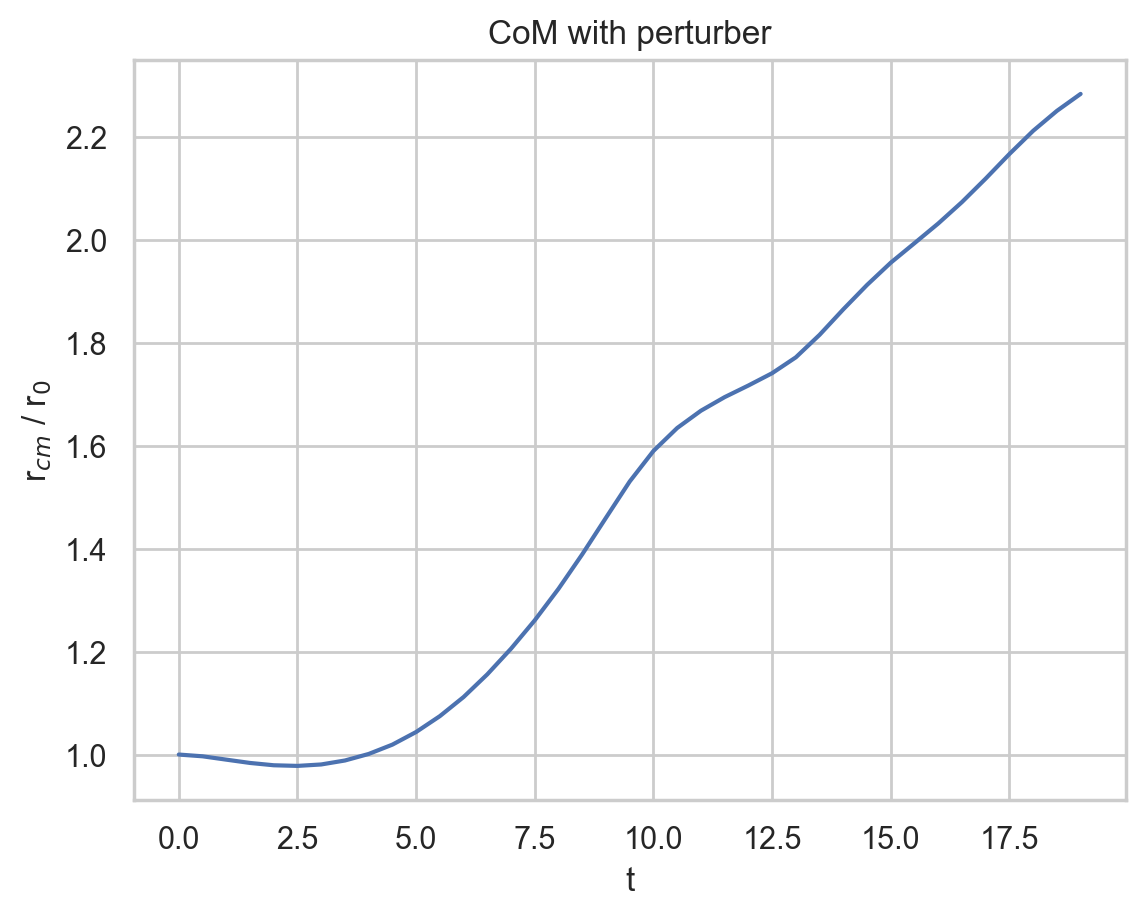

In [37]:
# with perturber
mu = m / (M+m_pert)


x_cm_tot = mu * np.sum(x_s_tot[np.where(r_s_tot[:,-1]<1000)], axis = 0)
y_cm_tot = mu * np.sum(y_s_tot[np.where(r_s_tot[:,-1]<1000)], axis = 0)
z_cm_tot = mu * np.sum(z_s_tot[np.where(r_s_tot[:,-1]<1000)], axis = 0)
r_cm_tot = np.sqrt(x_cm_tot**2 + y_cm_tot**2 + z_cm_tot**2)

plt.plot(t_s, r_cm_tot/r_cm_tot[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.title("CoM with perturber")
plt.xlabel('t');

##################################################################################

# without perturber


x_cm = mu * np.sum(x_s, axis = 0)
y_cm = mu * np.sum(y_s, axis = 0)
z_cm = mu * np.sum(z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

#plt.plot(t_s, r_cm/r_cm[0])
#plt.ylabel('r$_{cm}$ / r$_{0}$')
#plt.title("CoM without perturber")
#plt.xlabel('t');

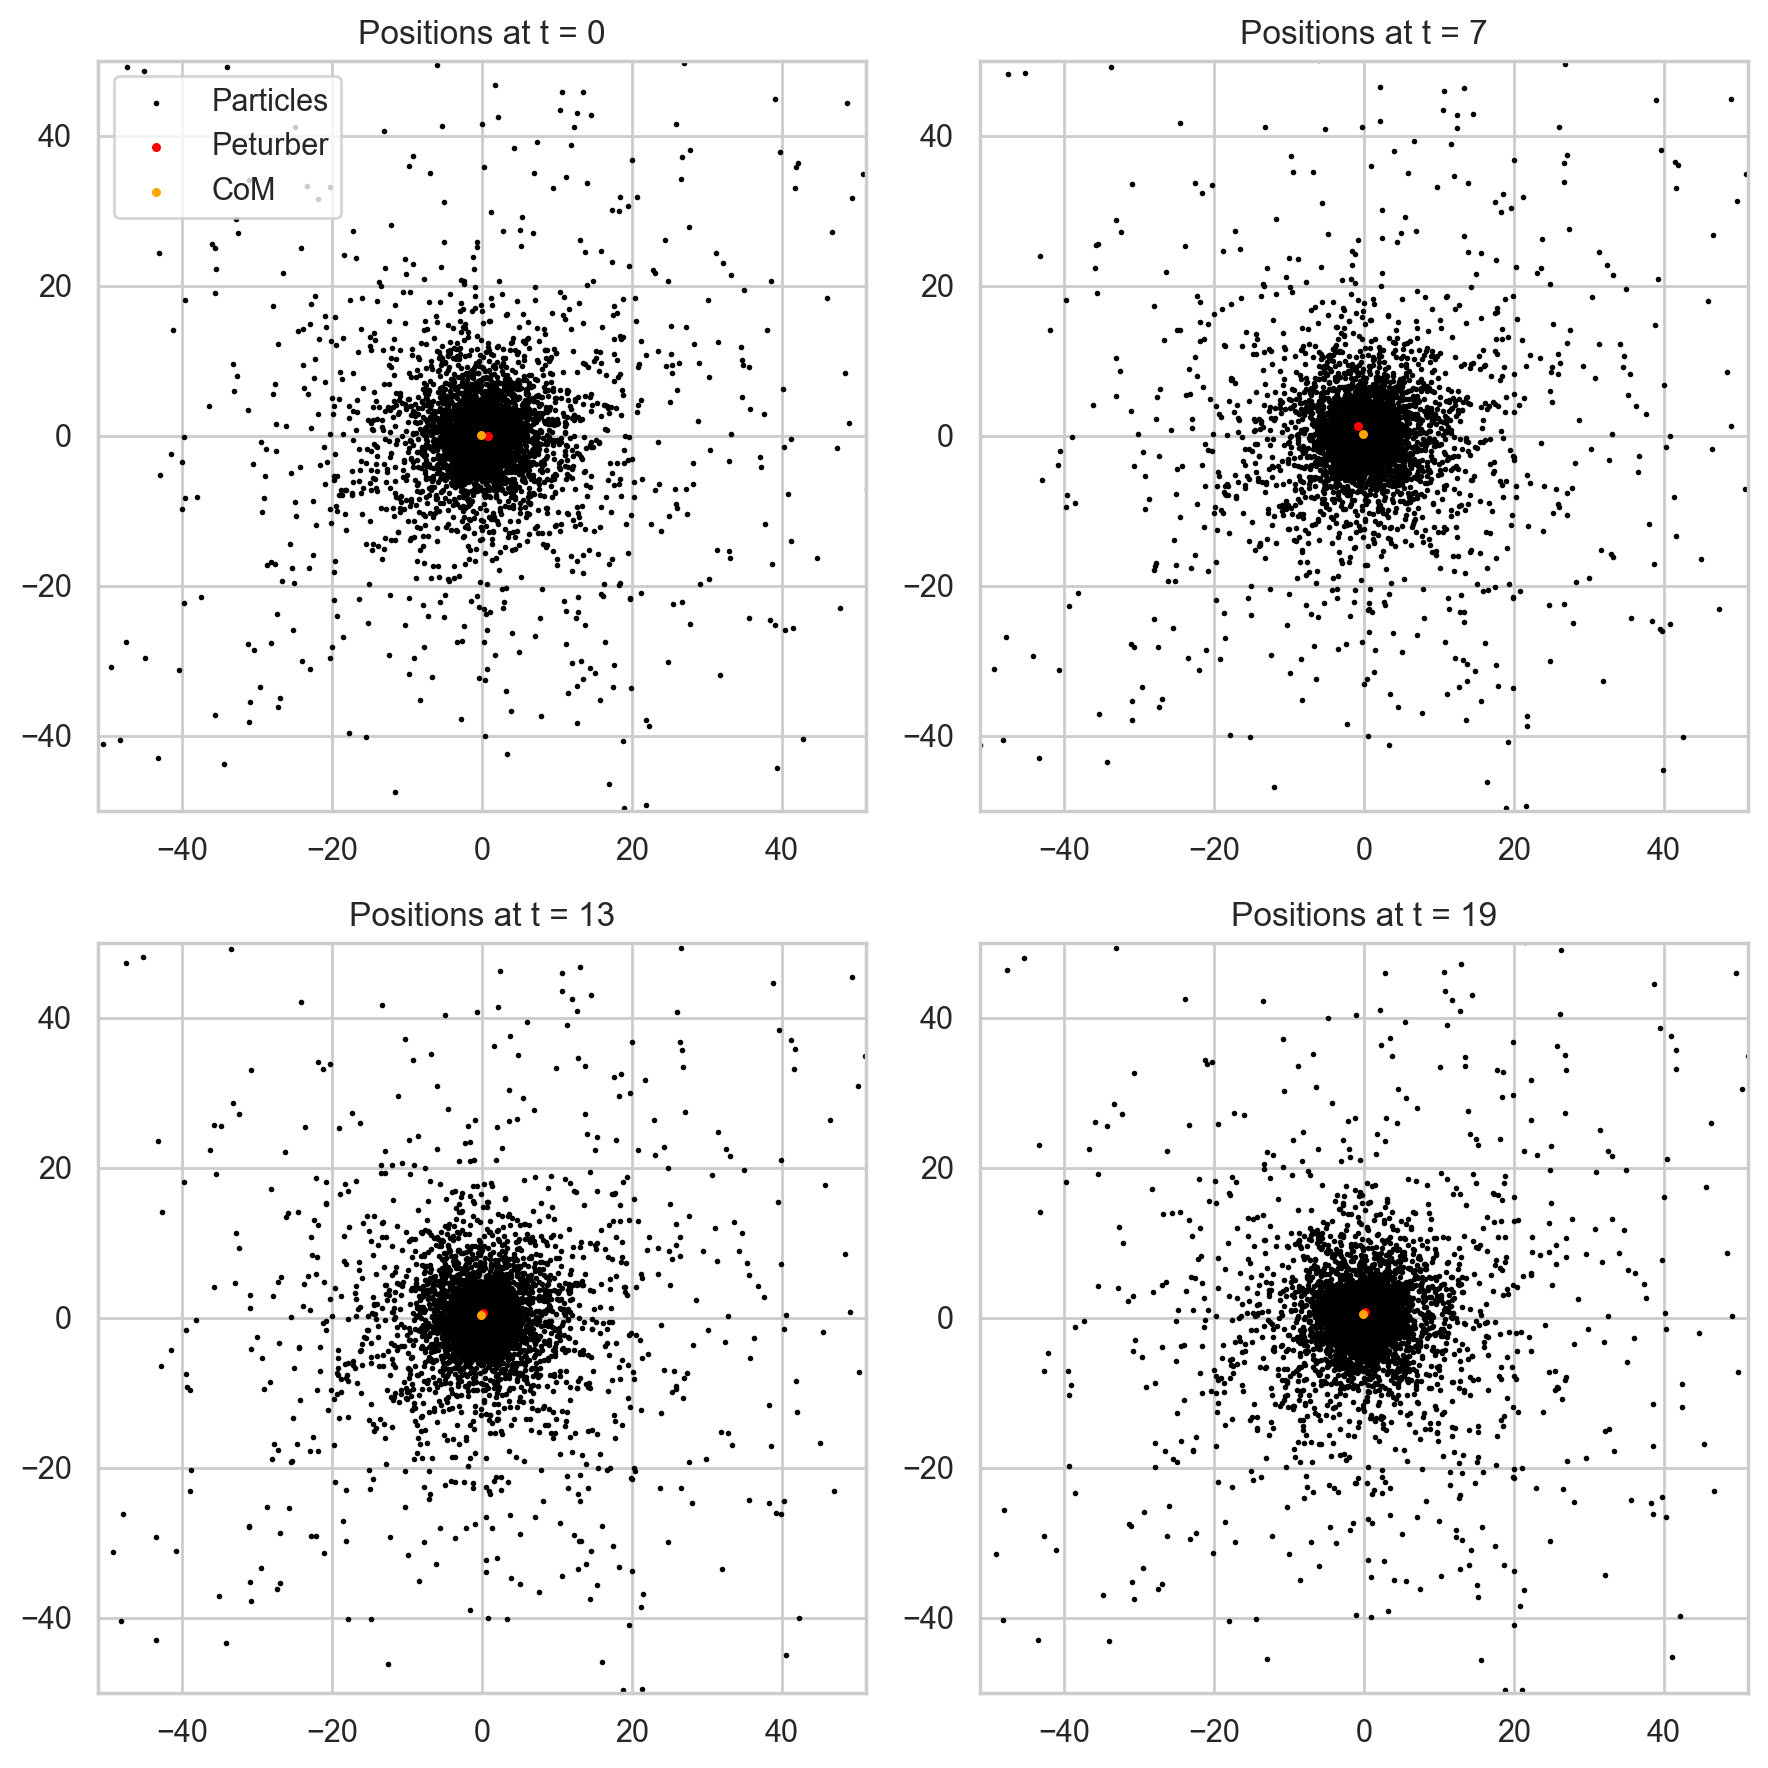

In [38]:
t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1

# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1, label='Particles')
ax[0][0].scatter(xp_s[t0], yp_s[t0], c='red', alpha=1, s=5, label='Peturber')
ax[0][0].scatter(x_cm_tot[t0], y_cm_tot[t0], c='orange', alpha=1, s=5, label='CoM')
ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
ax[0][0].axis('equal')
ax[0][0].set_xlim(-50, 50)
ax[0][0].set_ylim(-50, 50)
ax[0][0].legend()

# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1, label='Particles')
ax[0][1].scatter(xp_s[t1], yp_s[t1], c='red', alpha=1, s=5, label='Peturber')
ax[0][1].scatter(x_cm_tot[t1], y_cm_tot[t1], c='orange', alpha=1, s=5, label='COM')
ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].axis('equal')
ax[0][1].set_xlim(-50, 50)
ax[0][1].set_ylim(-50, 50)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1, label='Particles')
ax[1][0].scatter(xp_s[t2], yp_s[t2], c='red', alpha=1, s=5, label='Peturber')
ax[1][0].scatter(x_cm_tot[t2], y_cm_tot[t2], c='orange', alpha=1, s=5, label='COM')
ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].axis('equal')
ax[1][0].set_xlim(-50, 50)
ax[1][0].set_ylim(-50, 50)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1, label='Particles')
ax[1][1].scatter(xp_s[t3], yp_s[t3], c='red', alpha=1, s=5, label='Peturber')
ax[1][1].scatter(x_cm_tot[t3], y_cm_tot[t3], c='orange', alpha=1, s=5, label='COM')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].set_xlim(-50, 50)
ax[1][1].set_ylim(-50, 50)

plt.show()

### Lagrangian radii

  0%|          | 0/5 [00:00<?, ?it/s]

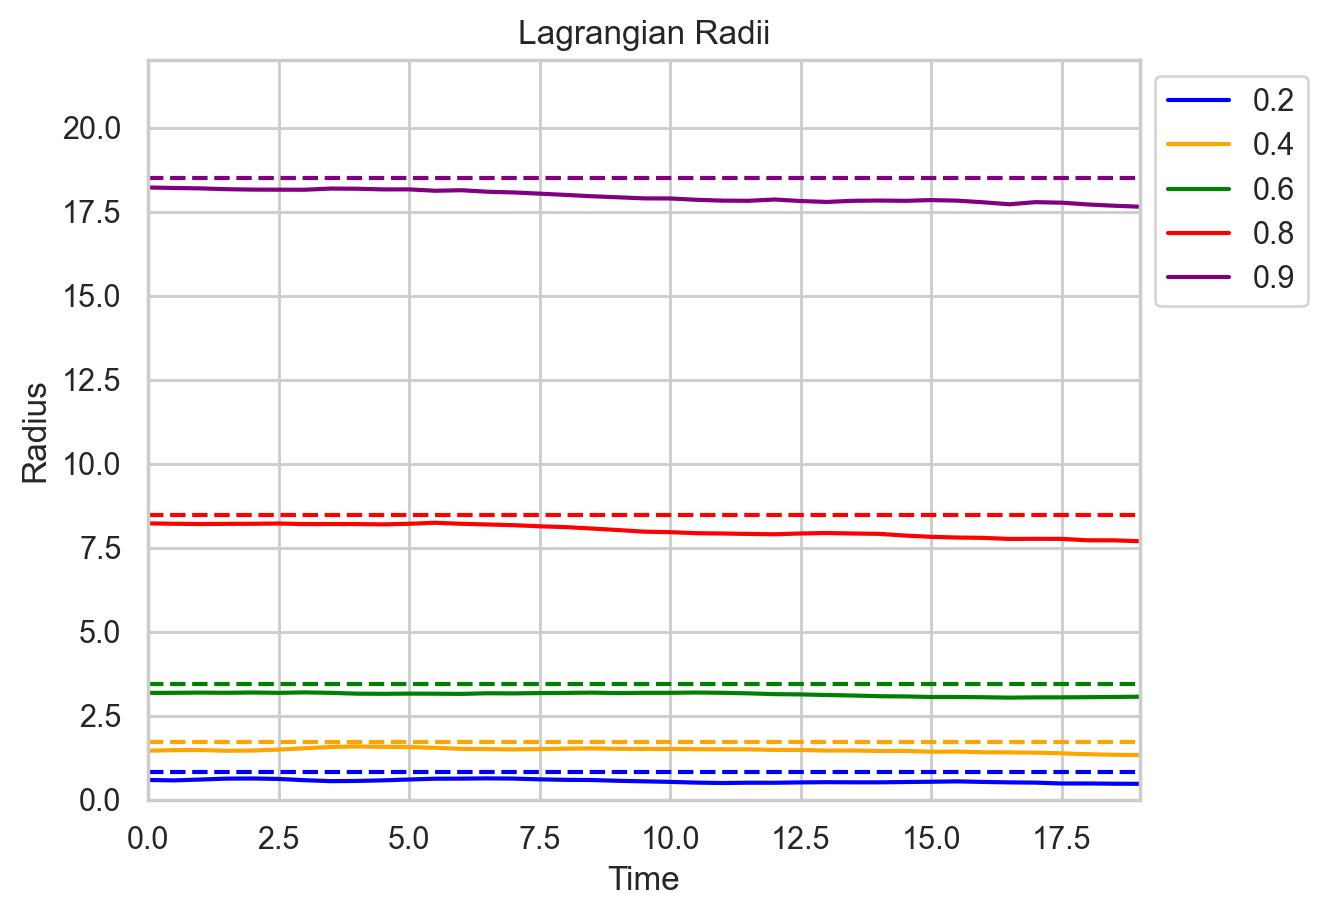

In [39]:
quantiles = [0.2,0.4,0.6, 0.8, 0.9]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'pink', 'grey']

for q, c in tqdm(zip(quantiles, colors), total=len(quantiles)):
    
    L_radii = []
    
    for i in range(len(t_s)):
        a    = np.sort(r_s[:,i]-r_cm_tot[i])
        mask = a<np.quantile(a,q)
        L_radii.append(np.max(a[mask]))
    
    L_radii = np.array(L_radii)
    L_th =(Rs*np.sqrt(q))/(1 - np.sqrt(q))
    
    plt.plot(t_s,L_radii, color=c, label=str(q))
    plt.axhline(y = L_th, color=c, linestyle='--')

plt.ylim(0,22)
plt.xlim(0, np.max(t_s))
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Lagrangian Radii')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig(f'Plots/Lagrangian Radii {N} teo.png' )

### Distribution check

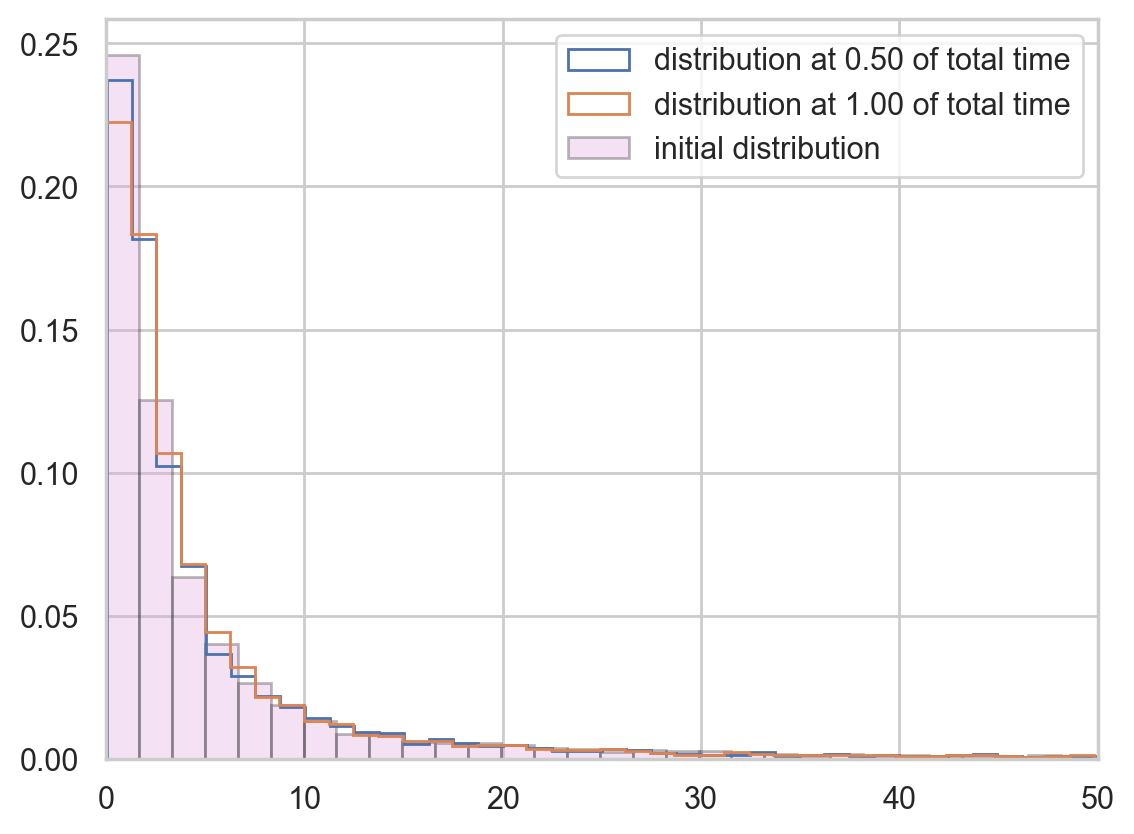

In [40]:
def distribution(frac):
    t = int(len(t_s)*frac)
    r_t = r_s[:,t-1]
    plt.hist(r_t[r_t<50], bins=40, density=True, histtype='step', label='distribution at %.2f of total time' %frac)

    
f=[0.5,1] #vectors of fractions
for frac in f:
    distribution(frac)
    
plt.hist(radii[radii<50], bins=30, density=True, alpha=0.3, color='plum', ec='k', histtype='bar', label='initial distribution');
plt.xlim(0,50)
plt.legend();

### Energy

In [41]:
# reading the output file
energy = pd.read_csv('logout_H_pert.txt', header=None).to_numpy()

# seleziono le righe dalle quali prendere i dati: sono quelle successive alle righe contenenti la aprola "time"
good_rows = [i+1 for i, row in enumerate(energy) if '        time' in row[0]]

# da queste righe prendo i dati
good_data = [energy[index] for index in good_rows] 
good_data = np.array(good_data)

In [42]:
time_energy = []
T   = []
U   = []

for i in range (0, len(good_data)):
    time_energy.append(float(good_data[i][0][6:12]))
    T.append(float(good_data[i][0][21:28]))
    U.append(float(good_data[i][0][30:36]))
                    
time_energy = np.array(time_energy)
T = np.array(T)
U = -np.array(U)
E_tot = T + U

mean_E   = np.average(E_tot)
E_stdev  = np.std(E_tot)

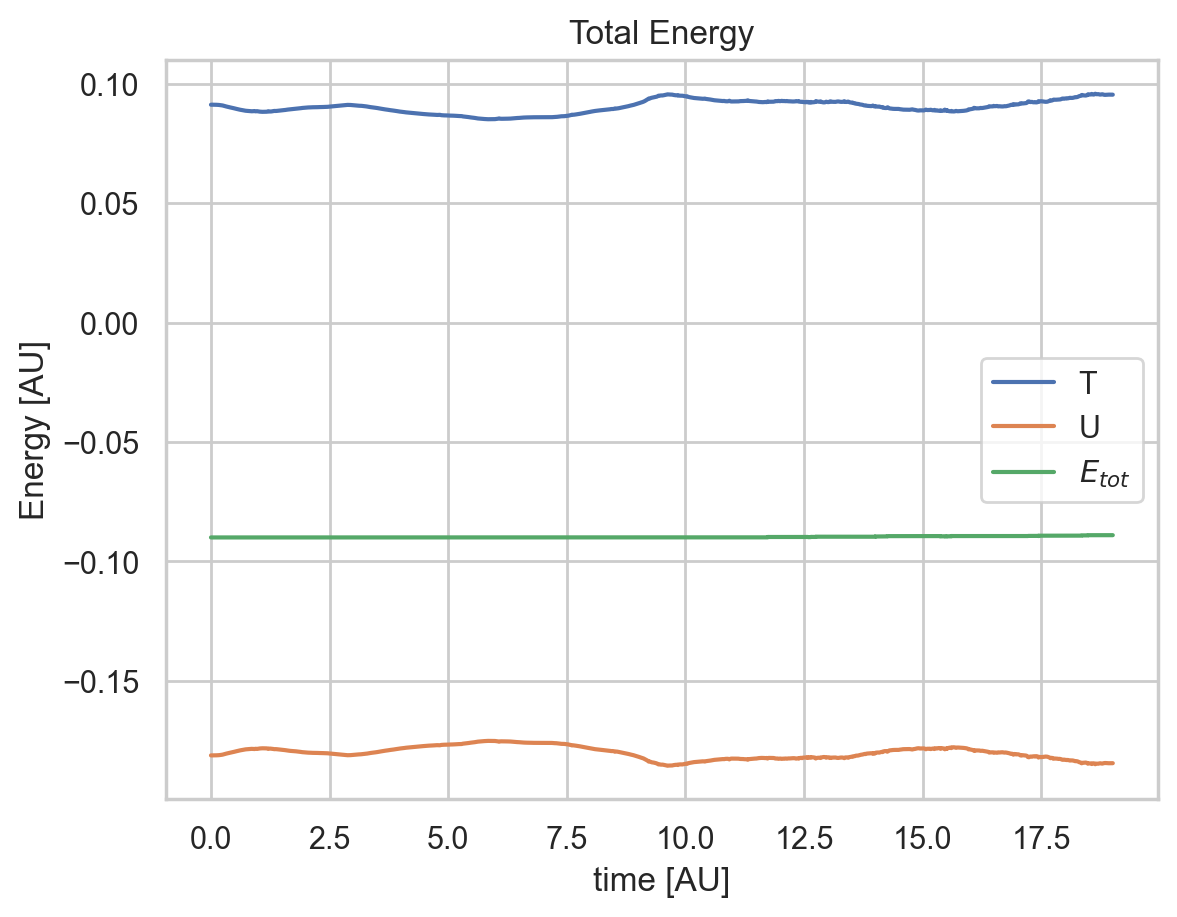

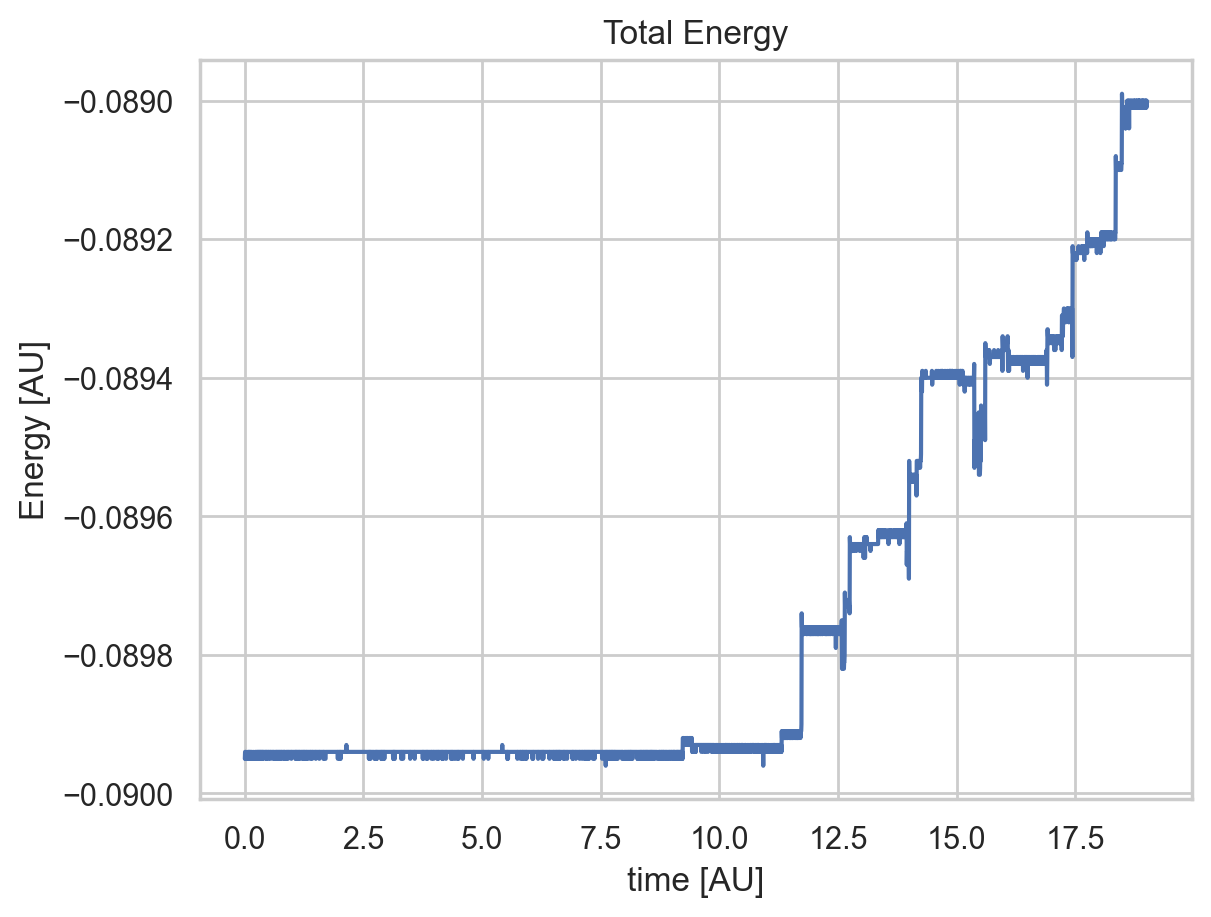

In [43]:
plt.plot(time_energy, T, label='T')
plt.plot(time_energy, U, label='U')
plt.plot(time_energy, E_tot, label=r'$E_{tot}$')

plt.xlabel('time [AU]')
plt.ylabel('Energy [AU]')
plt.title('Total Energy')
plt.legend()
plt.show()
############################################

plt.plot(time_energy, E_tot)
plt.xlabel('time [AU]')
plt.ylabel('Energy [AU]')
plt.title('Total Energy')
plt.show()

In [44]:
# relative error on total energy
rel_err = abs(E_stdev/mean_E)*100
print(f'Relative error: {rel_err:.2f} %')


Relative error: 0.31 %
